# Fake News Detection Challenge

### Description

The project was part of Data Cup 2019 Challenge. The goal of the competetion was **to create an artificial intelligence model that will distinguish between what's fact and what's fake news**. The following notebook is part of the solution for round 1.
You can find more about the challenge [here](https://www.datacup.ca/main/competitions/leadersprize2019/about)

### Data

The data is provided in train.zip, which contains two parts:
* train.json : metadata for each claim in the training set
* train_articles : folder of related articles for all the claims in the training set

In train.json, the following fields are provided for each claim:

1. “claim”: statement

    **Example:** "claim": "Viral posts claim that climate change is a \"made-up catastrophe.\""
    

2. “claimant”: entity who made the claim

    **Example:** "claimant": "Social media posts"
    

3. “date”: when the claim was made
   
    **Example:** "date": "2019-05-08"
    

4. “label”: truth labeling of the claim (0:false, 1:partly true, 2:true)
    
    **Example:** "label": 0
    

5. “related_articles”: list of source and supporting article ids (that point to files in train_articles ). Source articles denote articles that contain the claim, although the claim may be phrased differently in the article. Supporting articles denote articles that provide evidence that support the rating of the claim. Source and supporting articles are not distinguished in the list.
    
    **Example:** "related_articles": [20540, 38088, 14596, 20539, 20546, 38393, 20541, 41754]
    

6. “id”: unique identifier for each claim
   
    **Example:** “id”: 5

The folder train_articles contains text files where the name of each text file is an id to associate the article with a specific claim in train.json.
    **Example:** 20540.txt


You can download the data from [here](https://www.datacup.ca/main/competitions/leadersprize2019/data)

### Evaluation 

The goal here is to design an algorithms that assigns a “truth rating” of ‘TRUE’, ‘PARTLY TRUE’, or ‘FALSE’ to each claim in the test data set. You can read about the evaluation in detail [here](https://drive.google.com/file/d/1SZGYhJ7co1g9mI9qt6VMjGHLPxulrC9K/view?usp=sharing)

### Importing the required modules

In [1]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
import re, json
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import sent_tokenize
import nltk
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier  
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier   
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid

### Reading the train.json file 

In [2]:
# load metadata
with open(r"train.json", 'r') as f:
    metadata = json.load(f)
train_df=pd.DataFrame(metadata)
df = pd.DataFrame(metadata)

## *Step1. Data Exploration and Visualization*
**Below are the plots available for better understanding**
1. **News distribution over the time from 1986-2019**
    
    a. **Labels distribution** - *This gives more intutive knowledge on how the labels are spread across the time.* 
2. **Wordcloud plotted based on the labels** - *Gives knowledge on which words are most repeated for detecting the Fake news vs Real news*
3. **Claimants Distribution**
    
    a. **Labels distribution** - *This gives more intutive knowledge on how the labels are spread across withrespect to the claimant*

In [3]:
df['year'] = df['date'].apply(lambda x: x.split('-')[0])
df['year'].value_counts()
df['label'] =df['label'].map({0:'False', 1:'Partly True', 2: 'True'})

In [4]:
new =df['year'].value_counts().to_dict()

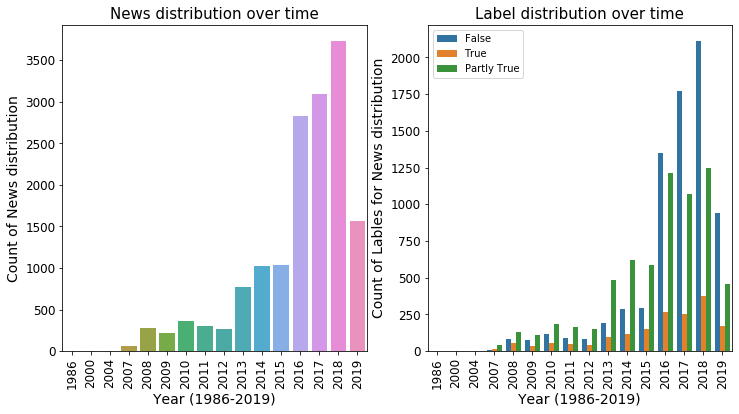

In [5]:
f, axes= plt.subplots(1,2, figsize=(12,6))
p1= sns.countplot(x="year", data=df, ax= axes[0])
p1.axes.set_title("News distribution over time",fontsize=15)
p1.set_xlabel("Year (1986-2019)",fontsize=14)
p1.set_ylabel("Count of News distribution",fontsize=14)
p1.tick_params(labelsize=12)
p1.set_xticklabels(labels= sorted(new.keys()), rotation=90)
p2= sns.countplot(x="year", data=df, hue= 'label', ax= axes[1])
p2.axes.set_title("Label distribution over time",fontsize=15)
p2.set_xlabel("Year (1986-2019)",fontsize=14)
p2.set_ylabel("Count of Lables for News distribution",fontsize=14)
p2.tick_params(labelsize=12)
p2.legend(loc='upper left')
p2.set_xticklabels(labels= sorted(new.keys()), rotation=90)
plt.show()

*From the above graph we can understand that most of the news is recent (2016-2019). However, **the fake news across all the years is significantly higher than True and Partly True**, which is a very important insight from the above graphs*

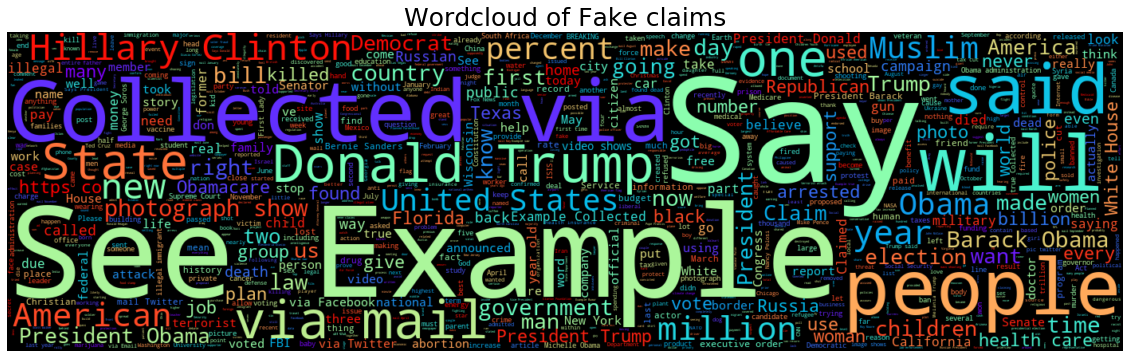

In [6]:
df1=train_df
df_false=df1[df1['label']==0]
df_true=df1[df1['label']==2]
df_partial=df1[df1['label']==1]
from wordcloud import WordCloud,STOPWORDS
column_start = df_false.claim
wc = (WordCloud(height=400,width=1400, max_words=1000, stopwords=STOPWORDS,
                colormap='rainbow',background_color='black'
              ).generate(' '.join(column_start.dropna().astype(str))))

 

plt.figure(figsize=(20,20))
plt.title("Wordcloud of Fake claims", fontsize=25)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

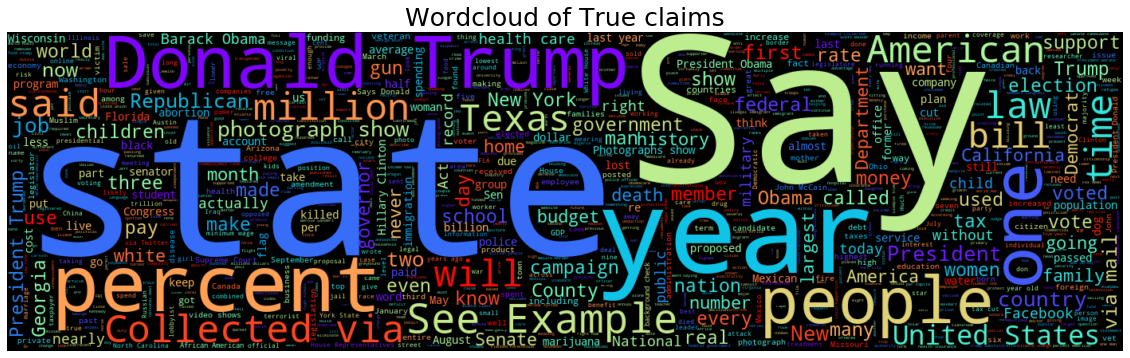

In [7]:
column_start = df_true.claim
wc = (WordCloud(height=400,width=1400, max_words=1000, stopwords=STOPWORDS,
                colormap='rainbow',background_color='black'
              ).generate(' '.join(column_start.dropna().astype(str))))
plt.figure(figsize=(20,20))
plt.title("Wordcloud of True claims", fontsize=25)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

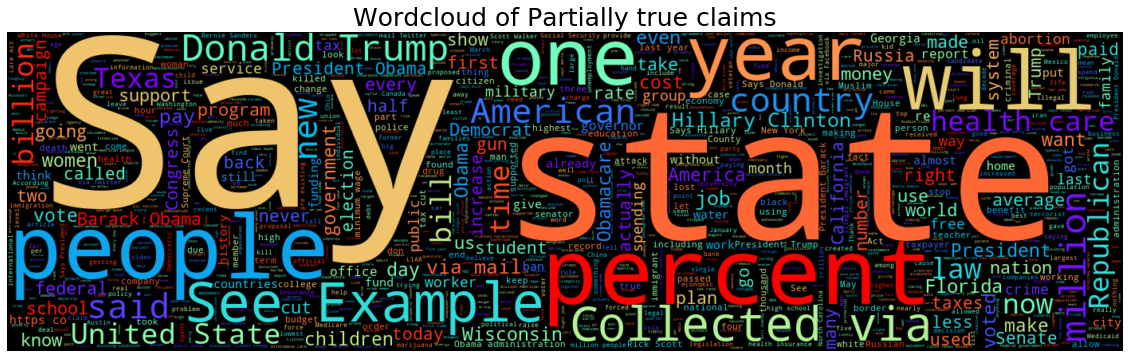

In [8]:
column_start = df_partial.claim
wc = (WordCloud(height=400,width=1400, max_words=1000, stopwords=STOPWORDS,
                colormap='rainbow',background_color='black'
              ).generate(' '.join(column_start.dropna().astype(str)))) 

plt.figure(figsize=(20,20))
plt.title("Wordcloud of Partially true claims", fontsize=25)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [9]:
claimants_keys=[]
claimants_values =[]
index = []
import operator
claimant_dict =df['claimant'].value_counts()[1:10].to_dict()
sorted_d = sorted(claimant_dict.items(), key=operator.itemgetter(1), reverse=True)

for i in sorted_d:
    claimants_keys.append(i[0])
    claimants_values.append(i[1])

for i in range(len(df)):
    if df['claimant'][i] in claimants_keys:
        index.append(i)
        
claimant_df = df.iloc[index].reset_index(drop=True)

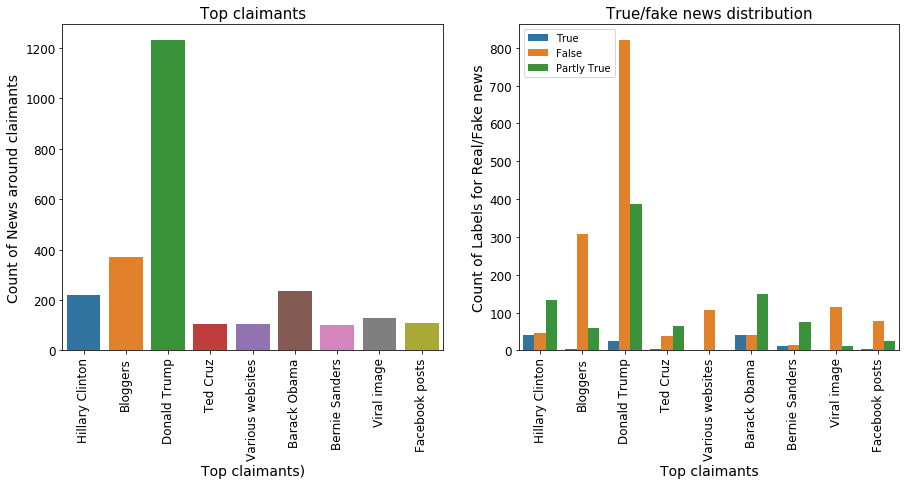

In [10]:
f, axes= plt.subplots(1,2, figsize=(15,6))
p1= sns.countplot(x="claimant", data=claimant_df, ax= axes[0])
p1.axes.set_title("Top claimants",fontsize=15)
p1.set_xlabel("Top claimants)",fontsize=14)
p1.set_ylabel("Count of News around claimants",fontsize=14)
p1.tick_params(labelsize=12)
p1.set_xticklabels(labels= claimant_df['claimant'].unique(), rotation=90)
p2= sns.countplot(x="claimant", data=claimant_df, hue= 'label', ax= axes[1])
p2.axes.set_title("True/fake news distribution",fontsize=15)
p2.set_xlabel("Top claimants",fontsize=14)
p2.set_ylabel("Count of Labels for Real/Fake news",fontsize=14)
p2.tick_params(labelsize=12)
p2.legend(loc='upper left')
p2.set_xticklabels(labels=claimant_df['claimant'].unique(), rotation=90)
plt.show()

*From the above graph we can understand that **Trump is the highest discussed claimant with most fake news associated with him**. This can be understood as he is the highest claimant with 1200 data points affliated to him.*

## Step 2. Feature Selection
    1. Each of the article_related field is read and the body field is created by concatinating all the documents (ex. if the first row has related articles of [12,15,256] all these text files are read and concatinated into a single document). 
    2. Cosine similarity of the documents is generated and we are selecting the top 5 sentences from the total document body using the claim column

*Cosine similarity is a metric used to measure how similar the documents are irrespective of their size. The cosine similarity is advantageous because even if the two similar documents are far apart by the Euclidean distance (due to the size of the document), chances are they may still be oriented closer together. The smaller the angle, higher the cosine similarity.*

*When plotted on a multi-dimensional space, where each dimension corresponds to a word in the document, the cosine similarity captures the orientation (the angle) of the documents and not the magnitude. If you want the magnitude, compute the Euclidean distance instead.*

*The cosine similarity is advantageous because even if the two similar documents are far apart by the Euclidean distance because of the size (like, the word ‘cricket’ appeared 50 times in one document and 10 times in another) they could still have a smaller angle between them. Smaller the angle, higher the similarity.*

In [11]:

def preprocess_articles():
    # load metadata
    with open("train.json", 'r') as f:
        metadata = json.load(f)
    n_claims = len(metadata)
    nltk.download('punkt')
    # load related articles for each claim
    relevant_sentences = []
    for id in range(n_claims):
        if id % 500 == 0:
            print("Claims preprocessed: ", id)

        # retrieve related articles
        related_articles = metadata[id]['related_articles']
        articles = ""
        for article_id in related_articles:
            # filename = "/usr/local/dataset/articles/" + str(article_id) + ".txt"
            filename = "train_articles/" + str(article_id) + ".txt"
            # concatenate related articles
            with open(filename, 'rb') as text_file:
                text = str(text_file.read())
                articles = articles + "\n" + text

        # split articles into sentences
        sentences = sent_tokenize(articles)

        # append claim to articles
        sentences.append(metadata[id]['claim'])

        # vectorize sentences based on tf-idf
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(sentences)

        # measure similarity between claim and each sentence
        similarity = X[-1, :] @ np.transpose(X[:-2, :])
        similarity = similarity.todense()

        # find top 5 sentences with greatest similarity
        sorted_index = np.argsort(similarity)
        top_sentences = []
        for i in range(1, min(5, sorted_index.shape[1]) + 1):
            top_sentences.append(sentences[sorted_index[0, -i]])
        relevant_sentences.append(top_sentences)

    return metadata, relevant_sentences

metadata, relevant_sentences = preprocess_articles()
print("Metadata of claim 0:")
print(metadata[0]['claim'])
print("Relevant sentences of claim 0:")
print(relevant_sentences[0])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Claims preprocessed:  0
Claims preprocessed:  500
Claims preprocessed:  1000
Claims preprocessed:  1500
Claims preprocessed:  2000
Claims preprocessed:  2500
Claims preprocessed:  3000
Claims preprocessed:  3500
Claims preprocessed:  4000
Claims preprocessed:  4500
Claims preprocessed:  5000
Claims preprocessed:  5500
Claims preprocessed:  6000
Claims preprocessed:  6500
Claims preprocessed:  7000
Claims preprocessed:  7500
Claims preprocessed:  8000
Claims preprocessed:  8500
Claims preprocessed:  9000
Claims preprocessed:  9500
Claims preprocessed:  10000
Claims preprocessed:  10500
Claims preprocessed:  11000
Claims preprocessed:  11500
Claims preprocessed:  12000
Claims preprocessed:  12500
Claims preprocessed:  13000
Claims preprocessed:  13500
Claims preprocessed:  14000
Claims preprocessed:  14500
Claims preprocessed:  15000
Claims preprocessed:  15500
Metadata of claim 0:
A line from George Orwell's novel 1984 predicts the power of smartphones.
Relevant sentences of claim 0:
["

In [12]:
train_df['relevant_sentenses'] = relevant_sentences
text =  train_df['relevant_sentenses']

## Step3: Data Cleaning
*The claims, as given, might not be in a form amenable to analysis. Therefore, the next step is to “clean” the data.*
    1. All html tags and attributes (i.e., /<[^>]+>/) are removed.
    2. Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
    3. All URLs are removed.
    4. All characters in the text are in lowercase.
    5. All stopwords are removed.

In [13]:
def preprocess_tweets(tweets):
    processed_features = []
    for sentence in range(0, len(tweets)):
        processed_feature = re.sub(r'\W', ' ', str(tweets[sentence])) # 
        processed_feature = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
        processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
        processed_feature = re.sub(r'^b\s+', '', processed_feature)
        processed_feature = processed_feature.lower()
        processed_features.append(processed_feature)
    return processed_features

txt_clean = preprocess_tweets(text)

In [14]:
train_df['relevant_sentenses'] = txt_clean
df_stop_words = pd.read_csv("stop_words.txt",delimiter=',')
stop_words = df_stop_words.iloc[:,0]
def rem_wrd(tweets):
    for s in range(0, len(tweets)):
        word_list = tweets[s].split()
        tweets[s] = ' '.join([i for i in word_list if i not in stop_words])
    return tweets

rm_txt = rem_wrd(txt_clean)

In [15]:
train_df['relevant_sentenses'] = rm_txt

In [16]:
df_stop_words = pd.read_csv("stop_words.txt",delimiter=',')
stop_words = df_stop_words.iloc[:,0]

In [17]:
def rem_wrd(tweets):
    for s in range(0, len(tweets)):
        word_list = tweets[s].split()
        tweets[s] = ' '.join([i for i in word_list if i not in stop_words])
    return tweets

In [18]:
rm_txt = rem_wrd(txt_clean)

In [19]:
train_df['rem_text'] = rm_txt 
train_df.head()

,claim,claimant,date,id,label,related_articles,relevant_sentenses,rem_text
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]",1984 by george orwell n1984 is dystopian novel...,1984 by george orwell n1984 is dystopian novel...
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]",his district includes greene and sabattus n em...,his district includes greene and sabattus n em...
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]",nb first person to complete nasa xe2 x80 x99s ...,nb first person to complete nasa xe2 x80 x99s ...
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]",all school children who have not yet had measl...,all school children who have not yet had measl...
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]",having actually done this can tell you insulti...,having actually done this can tell you insulti...


# Step 4: Data Modelling

**Features - "Claims", "Relevant_sentenses"**

**Target - "Label"**

*Used 'word' based Tfidvectorizer to create a term-frequency features to train a learning model*

*Tfidf = 'term frequency–inverse document frequency'*

*This will show how significant a word(or 'character' depending on hyperparameter) is to a text by calculating its frequency*

    Step 1. Tokenize the sentences
    Step 2. Create the Frequency matrix of the words in each sentence.
    Step 3. Calculate TermFrequency and generate a matrix
    Step 4. Creating a table for documents per words
    Step 5. Calculate IDF and generate a matrix
    Step 6. Calculate TF-IDF and generate a matrix
    Step 7. Score the sentences
    Step 8. Find the threshold
    Step 9. Generate the summary

In [20]:
X1 = train_df['claim']
X2 = train_df['rem_text']
y= train_df['label']

In [21]:
X1.shape

(15555,)

In [22]:
X2.shape

(15555,)

In [23]:
from sklearn.feature_selection import SelectPercentile, f_classif
vectorizer = TfidfVectorizer(analyzer='word',sublinear_tf=True, max_df=0.5, stop_words='english')
train1 = vectorizer.fit_transform(X1)
train2 = vectorizer.fit_transform(X2)

In [24]:
from scipy.sparse import hstack
train3 =hstack((train1, train2))

In [25]:
train3.shape

(15555, 119352)

## Step 5: Feature Selection

*Feature selection is the subsetting of relevant features (e.g. variables, predictors) for use in model construction. According to Jason Brownlee (2014), feature selection “reduces overfitting, improves accuracy, and reduces training time”.*

**SelectPercentile** - *Select features according to a percentile of the highest scores.*

In [26]:
features_train, features_test, labels_train, labels_test = train_test_split(train3, y, test_size=0.3, random_state=10)

selector = SelectPercentile(f_classif, percentile=10)
selector.fit(features_train, labels_train)
features_train = selector.transform(features_train).toarray()
features_test = selector.transform(features_test).toarray()

c:\users\harik\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  UserWarning)
c:\users\harik\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


## Step 6: Model Implementation
*We have implemented 5 models to find the best model*

*Logistic Regression*

*Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).*

*How does Logistic Regression model perform ? Whats is the train and test accuracy ?*

In [27]:
model = LogisticRegression()
model.fit(features_train, labels_train)
predictions_LR = model.predict(features_test)
y_train_pred = model.predict(features_train)
score_train = model.score(features_train, labels_train)
score_test = model.score(features_test, labels_test)

print("\nTrain set score:{}%".format(round(score_train*100, 3)))
print("Test set score: {}%".format(round(score_test*100, 3)))

c:\users\harik\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\harik\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)



Train set score:70.316%
Test set score: 61.624%


In [28]:
required_plots_df = pd.DataFrame(predictions_LR, columns=['predictions_LR'])

In [29]:
required_plots_df['true_labels'] = np.array(labels_test)
required_plots_df['true_labels'].value_counts()

0    2286
1    1879
2     502
Name: true_labels, dtype: int64

In [30]:
train_plot_df = pd.DataFrame(np.array(y_train_pred), columns=['y_train_pred'])
train_plot_df['labels_train'] = np.array(labels_train)


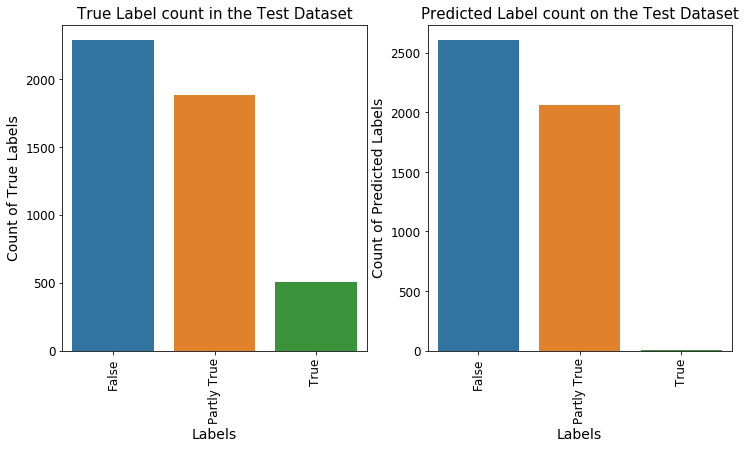

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
names = ['False', 'Partly True', 'True']
f, axes= plt.subplots(1,2, figsize=(12,6))
p1= sns.countplot(x="true_labels", data=required_plots_df, ax= axes[0])
p1.axes.set_title("True Label count in the Test Dataset",fontsize=15)
p1.set_xlabel("Labels",fontsize=14)
p1.set_ylabel("Count of True Labels",fontsize=14)
p1.tick_params(labelsize=12)
p1.set_xticklabels(labels= names, rotation=90)
p2= sns.countplot(x="predictions_LR", data=required_plots_df, ax= axes[1])
p2.axes.set_title("Predicted Label count on the Test Dataset",fontsize=15)
p2.set_xlabel("Labels",fontsize=14)
p2.set_ylabel("Count of Predicted Labels",fontsize=14)
p2.tick_params(labelsize=12)
p2.set_xticklabels(labels= names, rotation=90)
plt.show()

## *Inference*

*From the above graphs,it is evident that the number of false and partially true news are significantly higher than true news in the dataset provided to us. While the count of false and parly true news are above 1500, true news datapoints are just below 500. This is the clear reason why one sees extremely low count of predicted true news*

In [32]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fmt = '.2f' if normalize else 'd'

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=15)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = (cm.max()+cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=15)
    plt.xlabel('Predicted label', size=15)

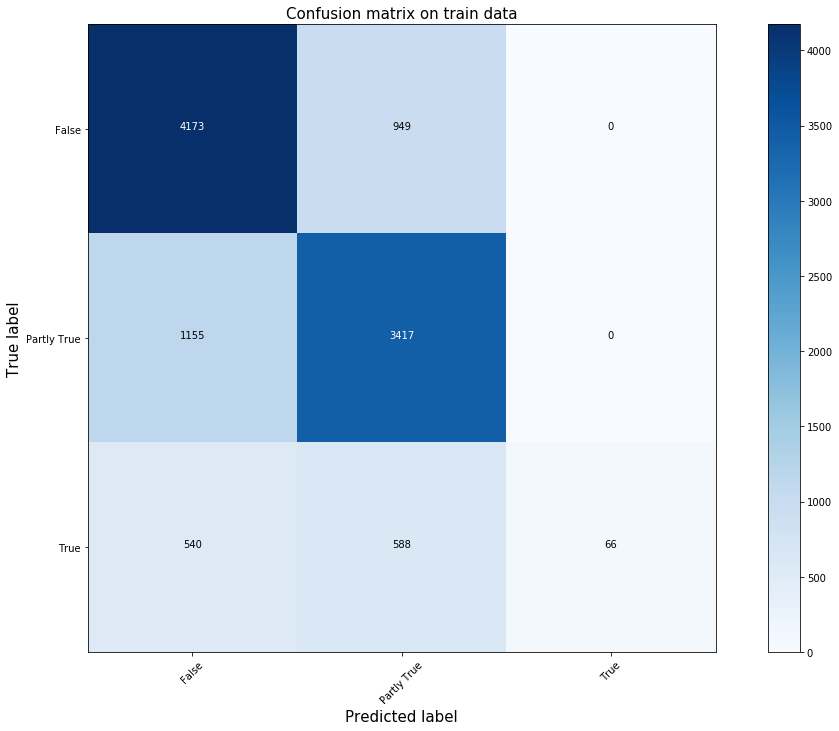

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import itertools
# Plot non-normalized confusion matrix
class_names = ['False','Partly True', 'True']
conf_mat_train = confusion_matrix(train_plot_df['labels_train'], train_plot_df['y_train_pred'])
plot_confusion_matrix(conf_mat_train, classes=class_names, title='Confusion matrix on train data')


## *Inference*

*The above confusion matrix represents the dataset we used for training. This again confirms our understanding that there are decent number of datapoints to train the model for false and partially true claims while not the case with true claims* 

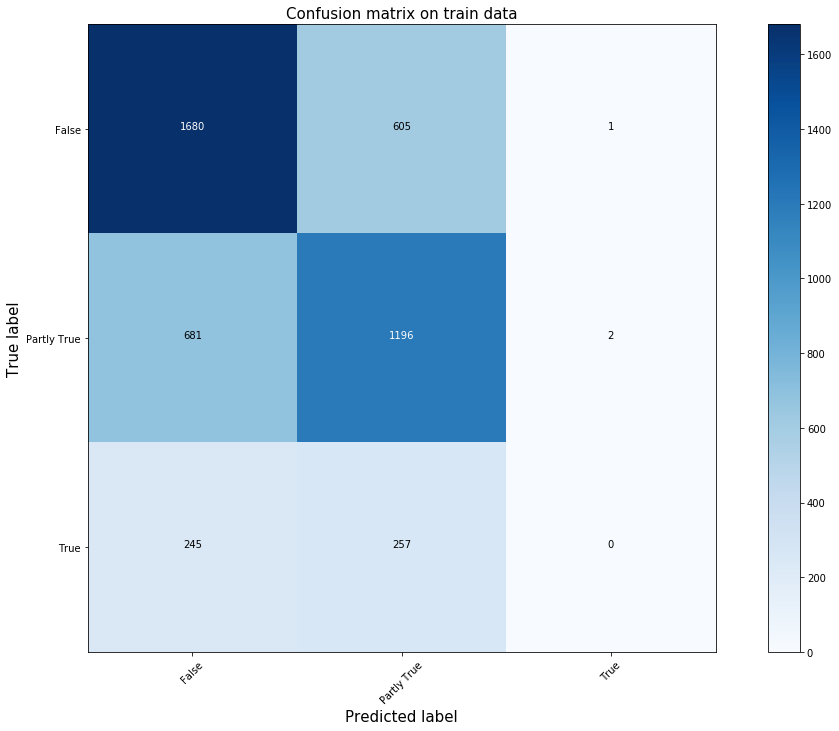

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
# Plot non-normalized confusion matrix

conf_mat_train = confusion_matrix(required_plots_df['true_labels'], required_plots_df['predictions_LR'])
plot_confusion_matrix(conf_mat_train, classes=class_names, title='Confusion matrix on train data')

## *Inference*

*The above confusion matrix helps us understand the distribution of predicted values. We see it very similar to the training dataset distribution*

*Let's take a look at other performance measures for the train set*

In [35]:
from sklearn.metrics import classification_report
print(classification_report(train_plot_df['labels_train'],  train_plot_df['y_train_pred'], target_names=class_names))

              precision    recall  f1-score   support

       False       0.71      0.81      0.76      5122
 Partly True       0.69      0.75      0.72      4572
        True       1.00      0.06      0.10      1194

    accuracy                           0.70     10888
   macro avg       0.80      0.54      0.53     10888
weighted avg       0.73      0.70      0.67     10888



*Let's take a look at other performance measures for test set*

In [36]:
from sklearn.metrics import classification_report
print(classification_report( required_plots_df['true_labels'],  required_plots_df['predictions_LR'], target_names=class_names))

              precision    recall  f1-score   support

       False       0.64      0.73      0.69      2286
 Partly True       0.58      0.64      0.61      1879
        True       0.00      0.00      0.00       502

    accuracy                           0.62      4667
   macro avg       0.41      0.46      0.43      4667
weighted avg       0.55      0.62      0.58      4667



*The other four models that we have used :*

**Multinomial NB**

*In machine learning, naïve Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features. They are among the simplest Bayesian network models.*

**Bernoulli NB**

*The difference is that while MultinomialNB works with occurrence counts, BernoulliNB is designed for binary/boolean features.*

**DecisionTree Classifier**

*In statistics, Decision tree learning uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves). It is one of the predictive modeling approaches used in statistics, data mining and machine learning. Tree models where the target variable can take a discrete set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees.*

**Nearest Centroid**

*In machine learning, a nearest centroid classifier or nearest prototype classifier is a classification model that assigns to observations the label of the class of training samples whose mean (centroid) is closest to the observation.*

In [74]:
models = [LogisticRegression(),MultinomialNB(), BernoulliNB(), DecisionTreeClassifier(), NearestCentroid()]

**Let's see how each of the above models perform**

In [75]:
def score(m):
    model = m
    model.fit(features_train, labels_train)
    score_train = round(model.score(features_train, labels_train)*100, 3)
    score_test = round(model.score(features_test, labels_test)*100, 3)
    print("\nTrain set score:{}%".format(score_train))
    print("Test set score: {}%".format(score_test))
    return score_train, score_test

In [76]:
scores_train = []
scores_test = []
for m in models:
    print('Model is:',m)
    score_train, score_test = score(m)
    scores_train.append(score_train)
    print(scores_train)
    scores_test.append(score_test)
    print(scores_test)
print('done')

Model is: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Train set score:70.316%
Test set score: 61.624%
[70.316]
[61.624]
Model is: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Train set score:66.238%
Test set score: 60.724%
[70.316, 66.238]
[61.624, 60.724]
Model is: BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Train set score:69.691%
Test set score: 60.66%
[70.316, 66.238, 69.691]
[61.624, 60.724, 60.66]
Model is: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, m

In [77]:
list(range(len(scores_train)))

[0, 1, 2, 3, 4]

**Visual Analysis of performance of different models**

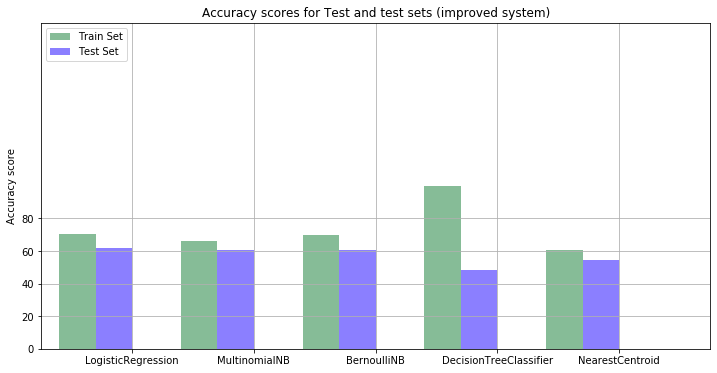

In [79]:
import matplotlib.pyplot as plt

width = 0.3

# IMPROVED_SYSTEM: Logistic, MNV, RF

# Plotting the bars
fig, ax = plt.subplots(figsize=(12,6))

pos = list(range(len(scores_train)))

plt.bar(pos, scores_train, width, alpha=0.5, color='#0f7a31', label='Train Set')
plt.bar([p + width for p in pos], scores_test, width, alpha=0.5, color='#1900ff', label='Test set')

# Set the y axis label
ax.set_ylabel('Accuracy score')

# Set the chart's title
ax.set_title('Accuracy scores for Test and test sets (improved system)')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(['LogisticRegression','MultinomialNB', 'BernoulliNB', 'DecisionTreeClassifier',\
                    'NearestCentroid'])
ax.set_yticks([0, 20, 40, 60, 80])


plt.legend(['Train Set', 'Test Set'], loc='upper left')


plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(scores_train + scores_test)*2])

plt.grid()
plt.show()

## Inference

*We can see the comparison between test and train accuracies for different algorithms.Logistic Regression and Multinomial NB are the better performing models when compared to the rest. We not only take in account of the train and test accuracy scores but also the difference between them. Lower difference means lower variance and optimal fitting of data*

*Implementing K-Fold cros validation on Logistic Regression model*

In [80]:
#Confidence Interval Function
import scipy.stats
from math import sqrt
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    mu,sd = np.mean(a),np.std(a)
    z = scipy.stats.t.ppf(confidence, n)
    h=z*sd/sqrt(n)
    return mu, h
def K_Fold_Log_Reg(data, target, num_run, **params):
    
    train_scores = []
    test_scores = []

    features = data
    
    classifier = LogisticRegression(C=params['c'], solver='liblinear')
    cv = StratifiedKFold(n_splits = 10, random_state = 2017)
    
    for i, (train, test) in enumerate(cv.split(features, target)):
        features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, stratify = target)
        clfModel = classifier.fit(features_train, target_train)
        train_target_pred = clfModel.predict(features_train)
        test_target_pred = clfModel.predict(features_test)
        train_score = metrics.accuracy_score(target_train, train_target_pred)
        test_score = metrics.accuracy_score(target_test, test_target_pred)
        print ("Fold {}: Train_Accuracy: {}% Test_Accuracy: {}%".format(i,\
                                    round(train_score*100,3), round(test_score*100,3))) 
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_mean,train_ci = mean_confidence_interval(train_scores)
    test_mean,test_ci = mean_confidence_interval(test_scores)    

    return train_mean,test_mean, train_ci, test_ci

In [81]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

y = train_df['label']
X_TFIDF = train3

train_mean,test_mean, train_ci, test_ci = K_Fold_Log_Reg(X_TFIDF, y, 10, c=1.0)

print("Average Train_Accuracy: {}%, Confidence_Interval: ({}%)".format(round(train_mean,3),\
                                                                       round(train_ci,5)))
print("Average Train_Accuracy: {}%, Confidence_Interval: ({}%)".format(round(test_mean,3), round(test_ci,5)))

Fold 0: Train_Accuracy: 83.725% Test_Accuracy: 61.024%
Fold 1: Train_Accuracy: 83.78% Test_Accuracy: 61.024%
Fold 2: Train_Accuracy: 84.396% Test_Accuracy: 60.831%
Fold 3: Train_Accuracy: 83.698% Test_Accuracy: 61.217%
Fold 4: Train_Accuracy: 83.643% Test_Accuracy: 61.388%
Fold 5: Train_Accuracy: 83.587% Test_Accuracy: 60.446%
Fold 6: Train_Accuracy: 83.744% Test_Accuracy: 61.796%
Fold 7: Train_Accuracy: 83.431% Test_Accuracy: 62.203%
Fold 8: Train_Accuracy: 83.486% Test_Accuracy: 60.274%
Fold 9: Train_Accuracy: 84.065% Test_Accuracy: 62.031%
Average Train_Accuracy: 0.838%, Confidence_Interval: (0.00155%)
Average Train_Accuracy: 0.612%, Confidence_Interval: (0.00349%)


## Hyper parameter Tuning

*In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are learned.*

*The same kind of machine learning model can require different constraints, weights or learning rates to generalize different data patterns. These measures are called hyperparameters, and have to be tuned so that the model can optimally solve the machine learning problem. Hyperparameter optimization finds a tuple of hyperparameters that yields an optimal model which minimizes a predefined loss function on given independent data.*

In [82]:
def hyperParameterAC(data,y, clf, num_run):
    """
    INPUT
        data: Dataframe. Pre-processed data
        clf: string. Name of the classifier from ['LR', 'SVM', 'NB']
    
    OUTPUT
        test_mean_hp: list.  mean accuracy list of test
        test_ci_hp: list. confidence interval list of test
        train_mean_hp: list. mean accuracy list of train
        train_ci_hp: list. confidence interval list of train
        
    NOTE 
        randomSplitCI could be the sub-route of this function
    """
    params = np.logspace(-4, 4, num=9)
    
    ########### your code goes here ###########

    train_scores = []
    test_scores = []
    train_mean_hp = []
    train_ci_hp = []
    test_mean_hp = []
    test_ci_hp = []
    for i in range(len(params)):
        
        features = data
        
        target = y

        
        if clf == "LR":
            classifier = LogisticRegression(C=params[i], solver='liblinear')
        elif clf == "NB":
            classifier = GaussianNB()
        
        for j in range(num_run):
            features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, stratify = target)
            clfModel = classifier.fit(features_train, target_train)
            train_target_pred = clfModel.predict(features_train)
            test_target_pred = clfModel.predict(features_test)
            # compute the confusion matrix on each fold, convert it to a DataFrame and stash it for later compute
            # stash the overall accuracy on the test set for the fold too
            train_scores.append(metrics.accuracy_score(target_train, train_target_pred))
            test_scores.append(metrics.accuracy_score(target_test, test_target_pred))     
            
        train_mean,train_ci = mean_confidence_interval(train_scores)
        test_mean,test_ci = mean_confidence_interval(test_scores) 
        train_mean_hp.append(train_mean)
        train_ci_hp.append(train_ci)
        test_mean_hp.append(test_mean)
        test_ci_hp.append(test_ci)

    ###########         end         ###########
    return train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp

In [87]:
train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp = hyperParameterAC(train3, y,'LR', 5)

In [91]:
train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp

([0.47621234386480527,
  0.47621234386480527,
  0.49752020573108013,
  0.5399614254224833,
  0.5991550330639235,
  0.6658706833210873,
  0.7136034428466463,
  0.7494030124908155,
  0.7772471222140582],
 [0.0,
  0.0,
  0.013644198075500848,
  0.03008611900516482,
  0.046947045010764035,
  0.06039968748297458,
  0.06140857263621733,
  0.0591910357029079,
  0.05605783195787539],
 [0.4763231197771588,
  0.4763231197771588,
  0.4929790729233626,
  0.5211592029140776,
  0.5401242768373687,
  0.5494964645382473,
  0.5537237136122931,
  0.5569959288622242,
  0.5592171987715163],
 [0.0,
  0.0,
  0.01066459546323985,
  0.020467400456057626,
  0.020764355126203175,
  0.01838366435109668,
  0.015974999608240052,
  0.01413338285546371,
  0.012631385706407327])

In [92]:
def hyperParameterPlot(params, train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp):
    # First illustrate basic pyplot interface, using defaults where possible.
    plt.figure()
    test_curve=plt.errorbar(params, test_mean_hp, color=sns.xkcd_rgb["pale red"], yerr=test_ci_hp)
    train_curve=plt.errorbar(params, train_mean_hp,color=sns.xkcd_rgb["denim blue"], yerr=train_ci_hp)
    plt.legend([test_curve, train_curve], ['Test', 'Train'])
    plt.xlabel('Parameter')
    plt.xscale("log")
    plt.ylabel('Accuracy')
    plt.title("Accuracy vs Parameters")
    plt.show()

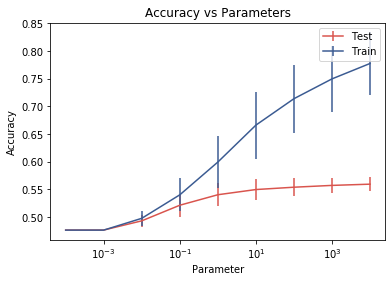

In [93]:
hyperParameterPlot(np.logspace(-4, 4, num=9),train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp)

*From the above plot, we can observe that at parameter c=1,test accuracy begins to stagnate. This implies that using c=1 will provide us the best results for Logistic regression model to detect fake news.*